SI valid pixels: 37685
SI stats: min 0.0 mean 0.1731881946325302 max 0.8727672696113586
Percentile 99: thr=0.501, components=104, patch candidates=104

Selected after min distance 8.0 km: 20 / 20

Top 5 sites:
   site_id        SI  patch_id                geometry
0        1  0.872767        12  POINT (361250 1036250)
1        2  0.803000        35   POINT (123750 861250)
2        3  0.797000        14  POINT (361250 1021250)
3        4  0.749996         1  POINT (441250 1133750)
4        5  0.729691        26   POINT (236250 926250)
Saved: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_sites/selected_sites_20.geojson
Saved: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_sites/selected_sites_20.shp


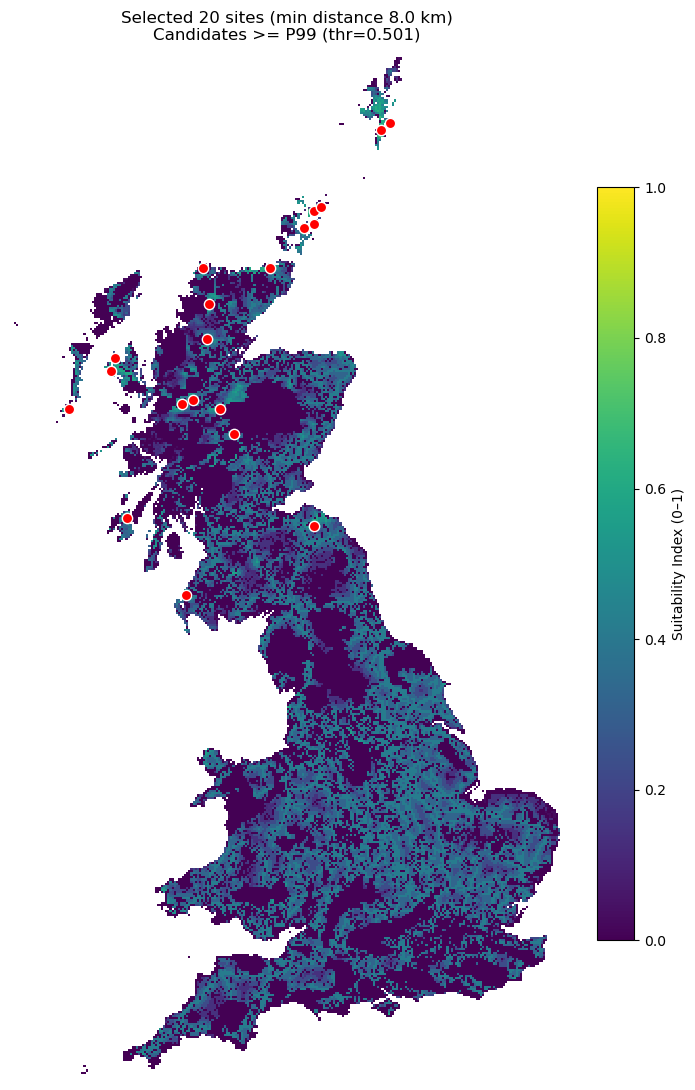

Saved: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_sites/selected_sites_base_red_dots.png


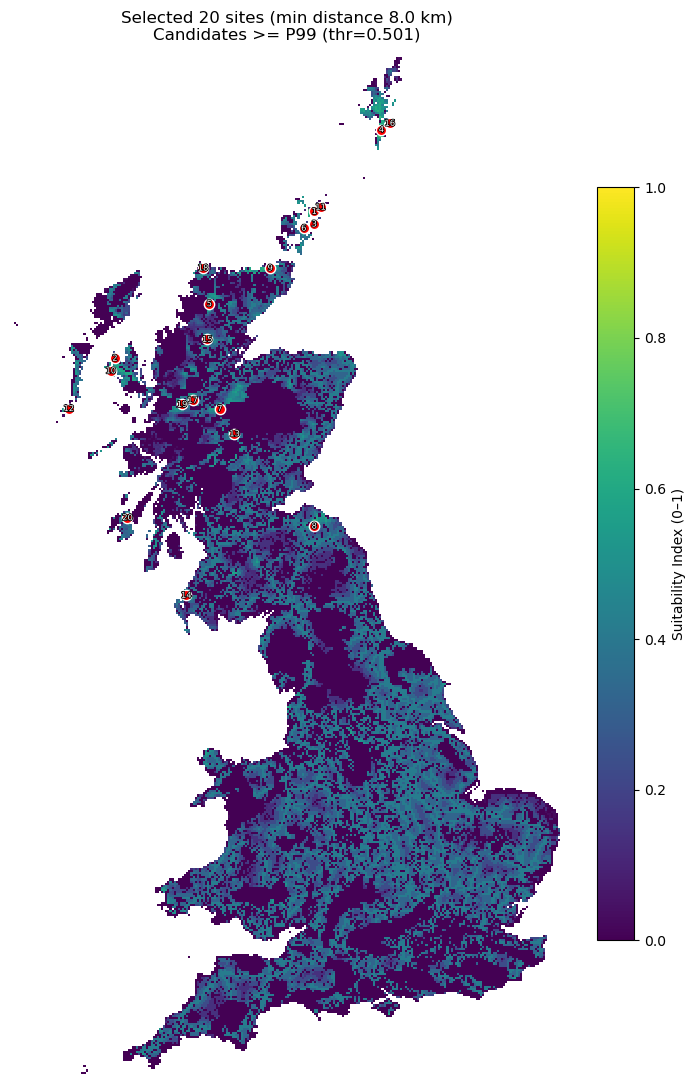

Saved: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_sites/selected_sites_center_numbers.png


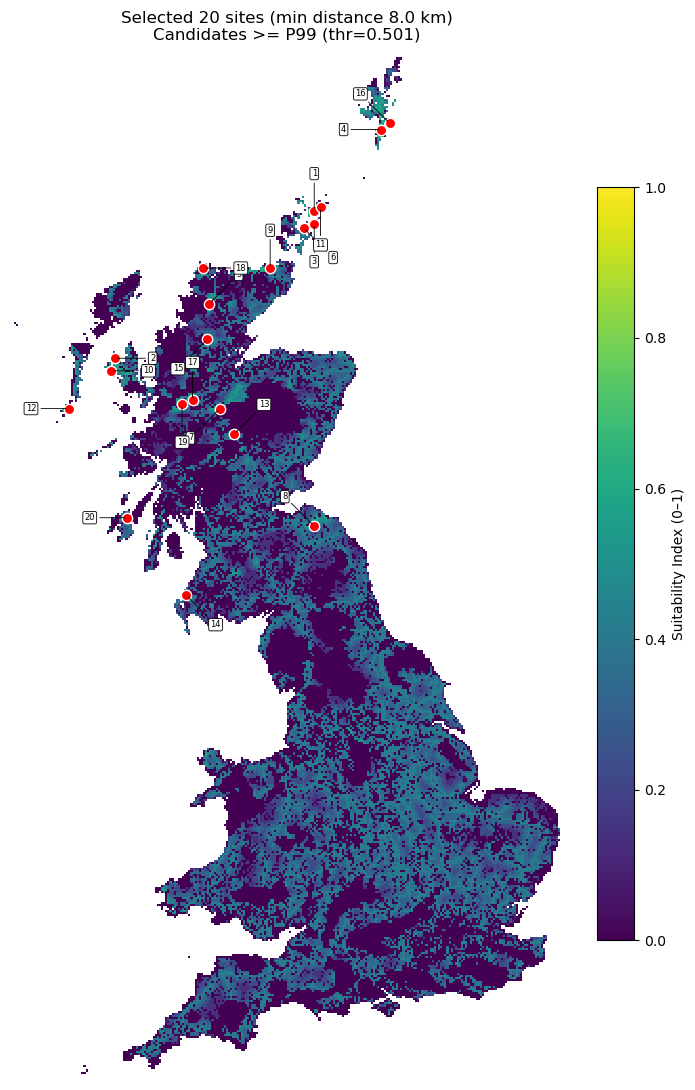

Saved: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_sites/selected_sites_callout_labels.png

All outputs saved to: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_sites
✅ Shapefile saved to: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_sites/selected_sites_20.shp


In [1]:
import os
import numpy as np
import rasterio
from rasterio.transform import xy
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from scipy.ndimage import label


DATA_DIR = "/Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets"

SI_TIF = os.path.join(DATA_DIR, "outputs_suitability", "suitability_index_0_1.tif")

OUT_DIR = os.path.join(DATA_DIR, "outputs_sites")
os.makedirs(OUT_DIR, exist_ok=True)

OUT_POINTS_GEOJSON = os.path.join(OUT_DIR, "selected_sites_20.geojson")
OUT_POINTS_SHP     = os.path.join(OUT_DIR, "selected_sites_20.shp")


OUT_MAP_PNG_BASE   = os.path.join(OUT_DIR, "selected_sites_base_red_dots.png")
OUT_MAP_PNG_CENTER = os.path.join(OUT_DIR, "selected_sites_center_numbers.png")
OUT_MAP_PNG_CALLOUT= os.path.join(OUT_DIR, "selected_sites_callout_labels.png")

N_SITES = 20


MIN_DISTANCE_KM = 8.0
MIN_DISTANCE_M = MIN_DISTANCE_KM * 1000.0


PERCENTILES_TO_TRY = [99, 98, 97, 96, 95, 93, 90, 88, 85, 80]


with rasterio.open(SI_TIF) as src:
    si = src.read(1).astype(np.float32)
    nodata = src.nodata
    transform = src.transform
    crs = src.crs

si = np.where(si == nodata, np.nan, si)

valid = np.isfinite(si)
if valid.sum() == 0:
    raise ValueError("SI 栅格没有有效值（全 NaN/nodata）。请检查 SI_TIF 路径或上一步输出。")

print("SI valid pixels:", int(valid.sum()))
print("SI stats:", "min", float(np.nanmin(si)), "mean", float(np.nanmean(si)), "max", float(np.nanmax(si)))


candidates = []
chosen_percentile = None
chosen_threshold = None

structure = np.ones((3, 3), dtype=np.uint8)  # 8-neighbour

for p in PERCENTILES_TO_TRY:
    thr = np.nanpercentile(si, p)
    mask = (si >= thr) & np.isfinite(si)

    lbl, ncomp = label(mask.astype(np.uint8), structure=structure)

    if ncomp == 0:
        print(f"Percentile {p}: thr={thr:.3f}, components=0 -> continue")
        continue

    patch_pts = []
    for comp_id in range(1, ncomp + 1):
        idx = np.where(lbl == comp_id)
        if idx[0].size == 0:
            continue
        vals = si[idx]
        k = int(np.nanargmax(vals))
        r = int(idx[0][k]); c = int(idx[1][k])

        x, y = xy(transform, r, c, offset="center")
        patch_pts.append((x, y, float(si[r, c]), int(comp_id)))

    patch_pts.sort(key=lambda t: t[2], reverse=True)

    print(f"Percentile {p}: thr={thr:.3f}, components={ncomp}, patch candidates={len(patch_pts)}")

    if len(patch_pts) >= N_SITES * 3: 
        candidates = patch_pts
        chosen_percentile = p
        chosen_threshold = thr
        break


if not candidates:
    p = PERCENTILES_TO_TRY[-1]
    thr = np.nanpercentile(si, p)
    mask = (si >= thr) & np.isfinite(si)
    lbl, ncomp = label(mask.astype(np.uint8), structure=structure)

    patch_pts = []
    for comp_id in range(1, ncomp + 1):
        idx = np.where(lbl == comp_id)
        if idx[0].size == 0:
            continue
        vals = si[idx]
        k = int(np.nanargmax(vals))
        r = int(idx[0][k]); c = int(idx[1][k])

        x, y = xy(transform, r, c, offset="center")
        patch_pts.append((x, y, float(si[r, c]), int(comp_id)))

    patch_pts.sort(key=lambda t: t[2], reverse=True)
    candidates = patch_pts
    chosen_percentile = p
    chosen_threshold = thr
    print(f"Fallback percentile {p}: thr={thr:.3f}, patch candidates={len(patch_pts)}")


selected = []
selected_xy = []

def far_enough(x, y, selected_xy, min_dist_m):
    for sx, sy in selected_xy:
        dx = x - sx
        dy = y - sy
        if (dx*dx + dy*dy) < (min_dist_m * min_dist_m):
            return False
    return True

for x, y, score, comp_id in candidates:
    if far_enough(x, y, selected_xy, MIN_DISTANCE_M):
        selected.append((x, y, score, comp_id))
        selected_xy.append((x, y))
    if len(selected) >= N_SITES:
        break

print(f"\nSelected after min distance {MIN_DISTANCE_KM} km: {len(selected)} / {N_SITES}")


if len(selected) < N_SITES:
    print("Not enough points -> relaxing threshold to fill up...")
    for p2 in [75, 70, 65, 60]:
        thr2 = np.nanpercentile(si, p2)
        mask2 = (si >= thr2) & np.isfinite(si)
        lbl2, ncomp2 = label(mask2.astype(np.uint8), structure=structure)

        patch_pts2 = []
        for comp_id in range(1, ncomp2 + 1):
            idx = np.where(lbl2 == comp_id)
            if idx[0].size == 0:
                continue
            vals = si[idx]
            k = int(np.nanargmax(vals))
            r = int(idx[0][k]); c = int(idx[1][k])
            x, y = xy(transform, r, c, offset="center")
            patch_pts2.append((x, y, float(si[r, c]), int(comp_id)))

        patch_pts2.sort(key=lambda t: t[2], reverse=True)

        for x, y, score, comp_id in patch_pts2:
            if far_enough(x, y, selected_xy, MIN_DISTANCE_M):
                selected.append((x, y, score, comp_id))
                selected_xy.append((x, y))
            if len(selected) >= N_SITES:
                break

        if len(selected) >= N_SITES:
            print(f"Filled to {len(selected)} using percentile {p2}")
            break


gdf = gpd.GeoDataFrame(
    {
        "site_id": list(range(1, len(selected) + 1)),
        "SI": [s[2] for s in selected],
        "patch_id": [s[3] for s in selected]
    },
    geometry=[Point(s[0], s[1]) for s in selected],
    crs=crs
).sort_values("SI", ascending=False).reset_index(drop=True)

print("\nTop 5 sites:")
print(gdf.head())

gdf.to_file(OUT_POINTS_GEOJSON, driver="GeoJSON")
print("Saved:", OUT_POINTS_GEOJSON)

gdf_shp = gdf.copy().rename(columns={"patch_id": "patchid"})  
gdf_shp.to_file(OUT_POINTS_SHP, driver="ESRI Shapefile")
print("Saved:", OUT_POINTS_SHP)


def points_to_pixel_xy(points_gdf, raster_path):
    with rasterio.open(raster_path) as src:
        inv = ~src.transform
        xs, ys = [], []
        for pt in points_gdf.geometry:
            col, row = inv * (pt.x, pt.y)
            xs.append(col); ys.append(row)
    return np.array(xs), np.array(ys)

xs, ys = points_to_pixel_xy(gdf, SI_TIF)


def plot_base_red_dots(save_path):
    plt.figure(figsize=(9, 11))
    cmap = plt.cm.viridis.copy()
    cmap.set_bad("white")

    im = plt.imshow(si, vmin=0, vmax=1, cmap=cmap, interpolation="nearest")
    plt.axis("off")
    plt.title(
        f"Selected {len(gdf)} sites (min distance {MIN_DISTANCE_KM} km)\n"
        f"Candidates >= P{chosen_percentile} (thr={chosen_threshold:.3f})",
        fontsize=12
    )

    plt.scatter(xs, ys, s=55, c="red", edgecolors="white", linewidths=1.0, zorder=5)

    plt.colorbar(im, fraction=0.046, pad=0.04, label="Suitability Index (0–1)")
    plt.tight_layout()
    plt.savefig(save_path, dpi=350, bbox_inches="tight")
    plt.show()
    print("Saved:", save_path)

plot_base_red_dots(OUT_MAP_PNG_BASE)


def plot_center_numbers(save_path):
    import matplotlib.patheffects as pe
    plt.figure(figsize=(9, 11))
    cmap = plt.cm.viridis.copy()
    cmap.set_bad("white")

    im = plt.imshow(si, vmin=0, vmax=1, cmap=cmap, interpolation="nearest")
    plt.axis("off")
    plt.title(
        f"Selected {len(gdf)} sites (min distance {MIN_DISTANCE_KM} km)\n"
        f"Candidates >= P{chosen_percentile} (thr={chosen_threshold:.3f})",
        fontsize=12
    )

    plt.scatter(xs, ys, s=55, c="red", edgecolors="white", linewidths=1.0, zorder=5)

    for i, (x, y) in enumerate(zip(xs, ys), start=1):
        t = plt.text(x, y, str(i), ha="center", va="center",
                     fontsize=6, color="white", zorder=6)
        t.set_path_effects([pe.withStroke(linewidth=1.2, foreground="black")])

    plt.colorbar(im, fraction=0.046, pad=0.04, label="Suitability Index (0–1)")
    plt.tight_layout()
    plt.savefig(save_path, dpi=350, bbox_inches="tight")
    plt.show()
    print("Saved:", save_path)

plot_center_numbers(OUT_MAP_PNG_CENTER)


def plot_callout_labels(save_path):
    plt.figure(figsize=(9, 11))
    cmap = plt.cm.viridis.copy()
    cmap.set_bad("white")

    im = plt.imshow(si, vmin=0, vmax=1, cmap=cmap, interpolation="nearest")
    plt.axis("off")
    plt.title(
        f"Selected {len(gdf)} sites (min distance {MIN_DISTANCE_KM} km)\n"
        f"Candidates >= P{chosen_percentile} (thr={chosen_threshold:.3f})",
        fontsize=12
    )

  
    plt.scatter(xs, ys, s=55, c="red", edgecolors="white", linewidths=1.0, zorder=5)

    
    offsets = [
        (0, -18), (18, 0), (0, 18), (-18, 0),
        (14, -14), (14, 14), (-14, 14), (-14, -14)
    ]

    for i, (x, y) in enumerate(zip(xs, ys), start=1):
        dx, dy = offsets[(i - 1) % len(offsets)]

        plt.annotate(
            text=str(i),
            xy=(x, y),                 
            xytext=(x + dx, y + dy),   
            textcoords="data",
            ha="center", va="center",
            fontsize=6,
            color="black",
            bbox=dict(
                boxstyle="round,pad=0.2",   
                fc="white",
                ec="black",
                lw=0.6
            ),
            arrowprops=dict(
                arrowstyle="-",           
                color="black",
                lw=0.6
            ),
            zorder=6
        )

    plt.colorbar(im, fraction=0.046, pad=0.04, label="Suitability Index (0–1)")
    plt.tight_layout()
    plt.savefig(save_path, dpi=350, bbox_inches="tight")
    plt.show()
    print("Saved:", save_path)

plot_callout_labels(OUT_MAP_PNG_CALLOUT)

print("\nAll outputs saved to:", OUT_DIR)

import geopandas as gpd
from shapely.geometry import Point
import os


OUT_DIR = "/Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_sites"
os.makedirs(OUT_DIR, exist_ok=True)

OUT_SHP = os.path.join(OUT_DIR, "selected_sites_20.shp")


gdf = gpd.GeoDataFrame(
    {
        "site_id": list(range(1, len(selected) + 1)),
        "SI": [s[2] for s in selected],
        "patchid": [s[3] for s in selected],  
    },
    geometry=[Point(s[0], s[1]) for s in selected],
    crs=crs   

gdf.to_file(OUT_SHP, driver="ESRI Shapefile")

print("✅ Shapefile saved to:", OUT_SHP)

